In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from collect_results import get_results_files, calculate_values_from_predictions_file, get_prediction_files, print_json_structure, get_common_prefix_limit, print_results_readable

import logging, sys
logging.disable(sys.maxsize)

In [2]:
import matplotlib.pyplot as plt

In [3]:
results_files_filters = ["/checkpoint/tbmihaylov/few_shot/2021-06-30-ppl-eval-moe/*207B*/*openbook*_results.json"]
results_files_filters = ["/checkpoint/tbmihaylov/few_shot/2021-06-14-ppl-eval/*6.7B*/*winogrande*fs0_results.json"]
results_files_filters = ["/checkpoint/tbmihaylov/few_shot/2021-06-14-ppl-eval/*/task.arceasy_tmp.arc_old_lang.en_calib.None_fs0_results.json"]
results_files_filters = ["/checkpoint/tbmihaylov/few_shot/2021-06-14-ppl-eval/*6.7B*/*arceasy*fs0_results.json"]

results_files = get_results_files(results_files_filters)

In [4]:
import re
        
def print_r0(s):
    print(s)
    
def print_readable_results(result_row, key_re = "*"):
    result_row = {k: v for k,v in result_row.items() if re.match(key_re, k)}
    max_len = max([len(x) for x in list((result_row.keys()))])
    for key, val in sorted(list(result_row.items()), key=lambda x: x[0], reverse=True):
        if isinstance(val, dict) and "mean" in val:
            val = round(val["mean"], 4)
            print_r0(f"{key.ljust(max_len)} = {val}")
        elif isinstance(val, float):
            val = round(val, 4)
            print_r0(f"{key.ljust(max_len)} = {val}")

In [5]:
def custom_score1(x):
    return np.sum(x)

def custom_score2(x):
    return np.sum(x)
    
res_file_results = []
for res_file in results_files:
    print(res_file)
    print("pred_files:")
    for pred_file_path in get_prediction_files(res_file):
        (
            calculated_values,
            per_item_values,
            items
        ) = calculate_values_from_predictions_file(
            pred_file_path,
            recalc_scores = True,
            score_funcs=[np.sum, np.mean, custom_score1, custom_score2],
            use_only_suffix_for_scoring=False,
            calibration=True,
            return_per_item_values=True,
            
            return_items = True,
            max_items = 0,
        )
        
        #print(calculated_values)
        print("-"*10)
        print_readable_results(calculated_values, "accuracy*")
        res_file_results.append((pred_file_path, calculated_values, per_item_values))
        print()
        break

/checkpoint/tbmihaylov/few_shot/2021-06-14-ppl-eval/arceasy_dense_6.7B_fs.0_32_t10_smpl.All_2021-06-17-22-53-16-350265/task.arceasy_tmp.arc_old_lang.en_calib.None_fs0_results.json
pred_files:
----------
accuracy_sum           = 0.6468
accuracy_mean          = 0.5944
accuracy_custom_score2 = 0.6468
accuracy_custom_score1 = 0.6468



# Explore single item

best: bool = 'False'
gold: bool = 'False'
score: float = '-4.622122764587402'
meta: dict
  ppl: float = '101.70970916748047'
  ppl_full: float = '47.860233306884766'
  score_raw: float = '-4.622122764587402'
  prompt: str = 'Which factor will most likely cause a person to develop a fever? It is a leg muscle relaxing after exercise.'
  positional_scores: list (22)
      item[0]: float = '-7.429856300354004'
  prompt_tokens: list (22)
      item[0]: int = '32251'


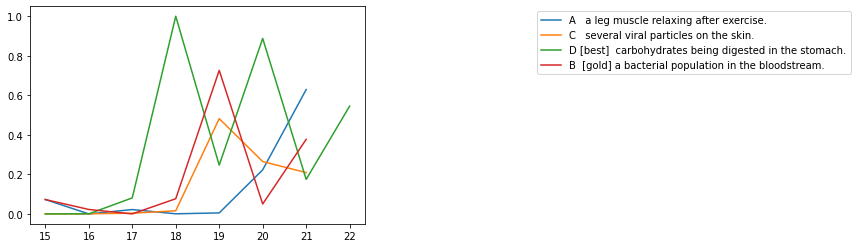

In [6]:
print_json_structure(items[0]["candidates"][0][1])

curr_item = items[0]

   
#def analyze_prediction(item):
fig, ax = plt.subplots()
common_tokens_limit = get_common_prefix_limit(curr_item, meta_field="prompt_tokens")
common_prompt_str_limit = get_common_prefix_limit(curr_item, meta_field="prompt")

suffix_only = True
for cand_lbl, cand in sorted(curr_item["candidates"], key=lambda x: x[1]["gold"]):
    pos_scores = cand["meta"]["positional_scores"]
    pos_scores = np.exp(pos_scores)
    pos_ids = range(len(pos_scores))
    
    #pos_scores = np.gradient(pos_scores, pos_ids)
    
    prompt_text = cand["meta"]["prompt"]
    
    if suffix_only:
        pos_scores = pos_scores[common_tokens_limit:]
        pos_ids = pos_ids[common_tokens_limit:]
        
        prompt_text = prompt_text[common_prompt_str_limit:]
        
    ax.plot(pos_ids, pos_scores, label=f'{cand_lbl} {"[best]" if cand["best"] else ""} {"[gold]" if cand["gold"] else ""} {prompt_text}')

plt.legend(bbox_to_anchor=(1.5, 1), loc='best', ncol=1)
    #ax.set_title()

    
    